# Bias-Variance Trade-off

[Last time](07_Intro_sklearn_student.ipynb), we started looking at linear regression and quickly touched on a few additional ML methods. We also briefly touched on the idea of splitting data into training and testing datasets. In this notebook, we'll explore this a bit more and address the bias-variance trade-off and model complexity.

We will grab a new dataset, the built in `diabetes` dataset and explore this using linear regression. Here's the information on that dataset:

The dataset for this example is another one built into `sklearn` and appears to originate from Efron *et al.* ([2003](https://hastie.su.domains/Papers/LARS/LeastAngle_2002.pdf)) and has 442 patients measured for 10 baseline variables and a response variable that measures disease progression one-year after baseline.

> Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.


In [228]:
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(as_frame=True) # Load it first as a dataframe to take a quick look at the data.
diabetes.frame.head()   

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [229]:
X_diabetes, y_diabetes = load_diabetes(return_X_y=True) # Reload for sklearn use

As a first start, let's do  a simple linear regression using blood pressure score (bp,column 3) and our target.

In [230]:
X_bp = X_diabetes[:,3, np.newaxis]
X_bp.shape

(442, 1)

Let's take a quick look at the data

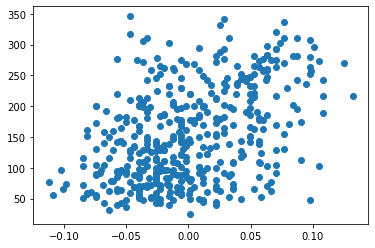

In [231]:
import matplotlib.pyplot as plt
plt.scatter(X_bp,y_diabetes)

This looks plausibly linear...right?? 🧐

Let's give it a quick shot...

R^2: 0.1949061431435003
MSE: 4774.113902368687


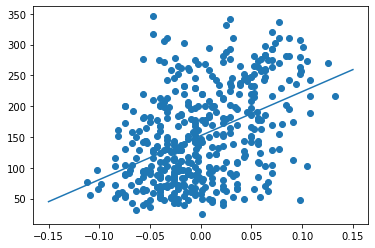

In [232]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_bp,y_diabetes)

def check_model(model, x, y):
    '''A function to get R^2 and plot regression'''
    
    Xfit = np.linspace(-0.15,0.15, len(y))[:, None] # Get some X-values for the fit curve
    yfit =  model.predict(Xfit) # Get the predicted y-values

    # Print model score R^2
    print(f'R^2: {model.score(x,y)}') # Get R^2 using the original data
    
    # Print MSE for the model
    print(f'MSE: {np.mean((y-model.predict(x))**2)}')
          
    # Visilize the results
    plt.scatter(x,y) # Scatter plot of our training data
    plt.plot(Xfit,yfit) # Our linear model
    
check_model(model, X_bp, y_diabetes)

## Pipelines and Polynomial features

That doesn't look too bad and more or less corresponds to what I was expecting. Our $R^2$, a measure of how much of the variation in the data is explained by the model, is only 0.19 though, so not the best...

One method to improve this is to add polynomial features--add the square of bp, the cube, etc. Let's explore that. We could make a dataframe manually that has bp and bp^2, but sklearn can do this for us. That is part of the `Pipeline` module.

We call `Pipeline()` and pass in a list of the objects we want included in the modeling pipeline.  Each pipeline component object needs to be placed in a tuple that includes a name for the pipeline step; e.g., `('name', pipeline_component)`.  After we've created our `Pipeline`, we can use it just like any model object in scikit-learn.  For example, we can call `fit()`, `predict()`, `score()`, and so on.

Note that, when using `LinearRegression` with `PolynomialFeatures`, you need to instantiate your `LinearRegression` object with the argument `fit_intercept=False`.

R^2: 0.19797897085384186
MSE: 4755.892387738325


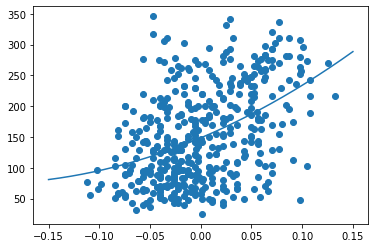

In [233]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linreg', LinearRegression(fit_intercept=False))
])

model.fit(X_bp,y_diabetes)

check_model(model, X_bp, y_diabetes)



Great! Our $R^2$ went up and out MSE went down!

Let's see if even higher order polynomials work even better!

R^2: 0.203956437355846
MSE: 4720.446699406303


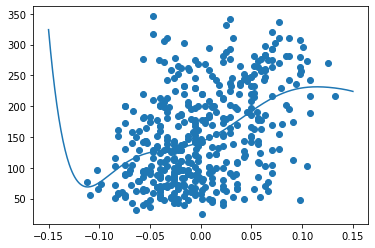

In [234]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=7)),
    ('linreg', LinearRegression(fit_intercept=False))
])

model.fit(X_bp,y_diabetes)

check_model(model, X_bp, y_diabetes)

As we keep adding higher order polynomials, $R^2$ does keep improving and MSE keep going down. For these data, we're not getting great fit, but hopefully you are starting to see a pattern here...the more complex the model, the better it will fit the data! But...remember we are using **all** the data and the more complex models are essentially fitting those data and will likely do a poor job of fitting new data that the model has not seen.

## The Bias-Variance Trade-off

Let's return to an example from the text, reworked a bit to fit with our `Pipeline` method

In [240]:
def PolynomialRegression(degree=2, **kwargs):
    return Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('poly', PolynomialFeatures(degree=degree)),
    ('linreg', LinearRegression(fit_intercept=False))
    ])

In [241]:
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

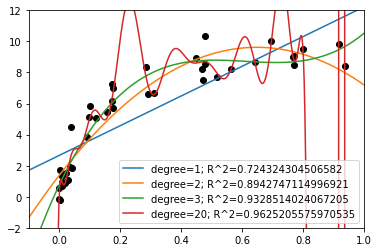

In [242]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 2, 3, 20]:
    model=PolynomialRegression(degree)
    y_test = model.fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label=f'degree={degree}; R^2={model.score(X,y)}')
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Again, as with the bp data, as we increase the polynomial order, the $R^2$ keeps going up. But hopefully it's clear that the 20th degree polynomial is fitting the training data and will not generalize well.

Quoting from the [text](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off):
> the straight-line model will never be able to describe this dataset well. Such a model is said to *underfit* the data: that is, it does not have enough model flexibility to suitably account for all the features in the data; another way of saying this is that the model has high *bias*.

Similarly:
> The [high-order polynomial] model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to *overfit* the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has high *variance*.

We scored the models using $R^2$. As the text notes:

> * For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
> * For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

This image from the text provides a great illustration of the bias-variance trade-off:

![PDSH Image showing bias-variance trade-off](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)

Again from the text:
> The diagram shown here is often called a validation curve, and we see the following essential features:
>
> * The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
> * For very low model complexity (a high-bias model), the training data is under-fit, which means that the model is a poor predictor both for the training data and for any previously unseen data.
> * For very high model complexity (a high-variance model), the training data is over-fit, which means that the model predicts the training data very well, but fails for any previously unseen data.
> * For some intermediate value, the validation curve has a maximum. This level of complexity indicates a suitable trade-off between bias and variance.

Another example that Brian Stucky introduced to help think about this is below.

Imagine the following table of data:

Name     | Class     | Can fly
---------|-----------|--------
Pileated woodpecker | Birds | Yes
Emu | Birds | No
Northern cardinal | Birds | Yes
Blacktip Shark | Cartilaginous fishes | No
Bluntnose stingray | Cartilaginous fishes | No
Black drum | Bony fishes | No
Florida carpenter ant | Insects | No
Periodical cicada | Insects | Yes
Luna moth | Insects | Yes

**Our task:** Develop a rule based model to predict whether an animal can fly.

**Model 1:** 
* If the animal is a bird or an insect, predict it can fly
* Otherwise, predict that it cannot fly
* **Accuracy: 0.78**

**Model 2:**
* If the species is a bird with a one-word name, predict that it cannot fly
* If it is a bird with a two-word name, predict that it can fly
* If it is an insect with a three-word name, predict that it cannot fly
* If it is an insect with a two-word name, predict that it can fly
* Otherwise, predict that it cannot fly
* **Accuracy: 1.00**

Which is a better model??

ok....Coming back to the text and having a look at the `validation_curve`:

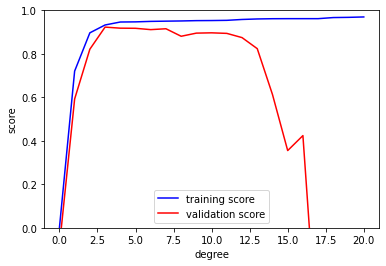

In [243]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(estimator = PolynomialRegression(), X = X,y= y,
                                          param_name ='poly__degree', param_range = degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

## Total Test Error = Bias + Variance + Error 

Let's take a look at some [slides](https://docs.google.com/presentation/d/1V6F2ZcYfosgc0HD8HF3aVkkIxGkAuNFa1dUGPMLNIro/edit?usp=sharing) that help reinforce the idea below that the total testing error = bias + variance + process error:

![Image showing that total testing error = bias + variance + process error](images/test_error_formula.png)


## The full diabetes dataset

Let's have a look at the full dataset and see if a model with all the features can help us out with this while still using linear regression.

First we'll relead the dataset, in case we lost it along the way in this notebook...

I'll note that in this case, the data are already scaled the similar sales. If they weren't, we would want to rescale things, which can be easily done in our `Pipeline` by adding a scaler: `('scaler', StandardScaler()),` at the start of the pipeline.

In [244]:
from sklearn.model_selection import train_test_split

# Reimport the data, jsut to be sure...
X_diabetes, y_diabetes = load_diabetes(return_X_y=True)

# Let's split the data into training/testing data
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes,
                                                random_state=1)

In [245]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('linreg', LinearRegression(fit_intercept=False))
])

model.fit(X_train,y_train)

print(f'Training data score: {model.score(X_train,y_train)}')
print(f'Testing data score: {model.score(X_test,y_test)}')


Training data score: 0.5359163748137687
Testing data score: 0.4439690125828367


## Cross valiadation

Above we looked at splitting the full dataset into training and testing sets. By default `sklearn`'s `train_test_split` will use 0.25, or train on 75% of the data and test on 25% of the data.

For the diabetes data, that probably isn't a huge deal since there's 442 samples. Because of that, and because we weren't getting the best results with this model anyway, let's load the data that were generated for the [slides](https://docs.google.com/presentation/d/1V6F2ZcYfosgc0HD8HF3aVkkIxGkAuNFa1dUGPMLNIro/edit?usp=sharing). It doesn't really matter for this, but just to throw it out there, the formula used to generate the data was:

$$ y = \frac{1}{2} \cos(3\pi x) + \frac{3\pi x}{5} + \epsilon ,$$

where $Var[\epsilon] = 0.5$.

The file at `data/weird_function_data.csv` has 100 data points generated using this function. We'll load that and split the data, using 50% for training and 50% for testing. Then we'll fit models with different numbers of polynomial features, estimate and plot the error.

In [246]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/weird_function_data.csv')

X = df[['x']] # Get the x values
y = df.y # get the y values


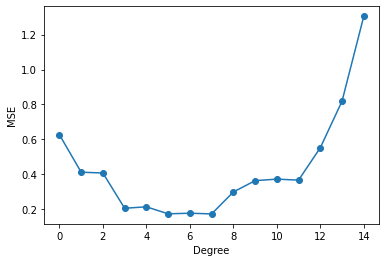

In [252]:
#Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

def mse(model, x, y):
    return np.mean((y-model.predict(x))**2)
    
err = []
degrees = range(15)

for degree in degrees:
    # Make our model
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linreg', LinearRegression(fit_intercept=False))
    ])

    # Fit the model
    model.fit(X_train,y_train)
    err.append(mse(model, X_test, y_test)) # Get MSE for model and append to list

err_df = pd.DataFrame({'degree':degrees, 'mse':err})

# Line plot
plt.plot(err_df['degree'], err_df['mse'], label='MSE by Degree')

# Overlay points
plt.scatter(err_df['degree'], err_df['mse'])

# Adding labels and title
plt.xlabel('Degree')
plt.ylabel('MSE')

# Display the plot
plt.show()
                       

Run the above code each time...you should get quite different results with each realization. Each run splits the data into training and testing datasets randomly. With each split, we get quite different values for out error estimates.

Especially with smaller datasets, we can't just run a single realization and pick a number of parameters with the lowest error! 

The variance is related to the dataset size, so this is more pronounced with smaller datasets. Making this worse, we have 100 data points, but are only using 50 to estimate the model.

Depending on the data, we're potentially losing a lot of data here by fitting our model on only half the data.

### $k$-fold Cross-validation

_$k$-fold cross-validation_ is a technique that overcomes some of the problems with using a single train/validation split.  The idea is that we randomly split our dataset into $k$ (approximately) equal-sized subsets.  We use each subset as the validation set in turn, yielding a total of $k$ estimates of our test error, which we then average to obtain our final test error estimate.  (Note that the way I am using our custom $MSE$ function in `cross_val_score()` is a little bit of a hack.  See the [scki-kit learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for the approved way of doing this.)

Here's the image from the text on this:

![PDSH diagram illustrating k-fold cross-validation](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-5-fold-CV.png)



In [273]:
from sklearn.model_selection import cross_val_score, KFold

model = Pipeline([
    ('poly', PolynomialFeatures(degree=5)),
    ('linreg', LinearRegression(fit_intercept=False))
])


kf = KFold(n_splits=10, shuffle=True)
res = cross_val_score(model, X, y, cv=kf, scoring=mse)
    
print(res)
print(f'Average MSE: {res.mean()}')

[0.16042887 0.19611406 0.1527627  0.32651884 0.2794222  0.20824802
 0.12784772 0.24684536 0.09724325 0.26380886]
Average MSE: 0.20592398589394906


Now, let's run this for all the degrees like we did above for the simple train-test split:

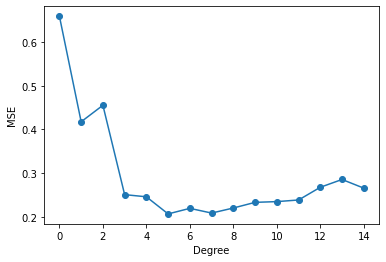

In [268]:
    
err = []
degrees = range(15)

kf = KFold(n_splits=10, shuffle=True)

for degree in degrees:
    # Make our model
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linreg', LinearRegression(fit_intercept=False))
    ])

    # Fit the model
    res = cross_val_score(model, X, y, cv=kf, scoring=mse)
    err.append(res.mean()) # Get MSE for model and append to list

err_df = pd.DataFrame({'degree':degrees, 'mse':err})

# Line plot
plt.plot(err_df['degree'], err_df['mse'], label='MSE by Degree')

# Overlay points
plt.scatter(err_df['degree'], err_df['mse'])

# Adding labels and title
plt.xlabel('Degree')
plt.ylabel('MSE')

# Display the plot
plt.show()
                       

Now, when we run this multiple times, the shape should stay more similar, and we see that the 5th degree polynomial generally has the lowest error.

The extreme case of $k$-fold cross-validation is where the number of folds, $k$, is equal to the number of data points. In that case, we train on all but one in each fold, cycling through each data point. This is refereed to as **leave-one-out cross-validation**.


## Grid Search to select best model hyperparameters

The polynomial degree, is one hyperparameter we can use in building our model. So far, we've left other hyperparameters as their defaults. We could systematically work through all the different combinations, but even when this is practical, it is tedious!

`sklearn` provides a handy `grid_search` to help automate this, at least in cases where it is practical.


In [274]:
from sklearn.model_selection import GridSearchCV

param_grid = {'poly__degree': np.arange(21),
              'linreg__fit_intercept': [True, False],
              'scaler__with_mean': [True, False],
              'scaler__with_std': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [275]:
# Once we call the .fit method all the models will be fit
grid.fit(X,y)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('linreg',
                                        LinearRegression(fit_intercept=False))]),
             param_grid={'linreg__fit_intercept': [True, False],
                         'poly__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]),
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

In [276]:
# The best parameters are stored in grid.best_params_
grid.best_params_

{'linreg__fit_intercept': False,
 'poly__degree': 3,
 'scaler__with_mean': False,
 'scaler__with_std': True}

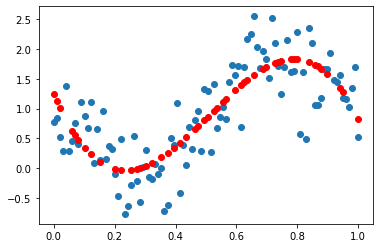

In [277]:
# We can then use the model using grid.best_estimator_
model = grid.best_estimator_

# Predict our y's using the model
y_test = model.fit(X,y).predict(X_test)


# Plot the data in blue and the predicted data in red.
plt.scatter(X,y) # Scatter plot of our training data
plt.scatter(X_test,y_test, color='red') # Our linear model
    